In [1]:
!pip install tfrecord_lite
!pip install jiwer

     |████████████████████████████████| 81kB 7.2MB/s 
  Created wheel for tfrecord-lite: filename=tfrecord_lite-0.0.7-cp37-cp37m-linux_x86_64.whl size=402127 sha256=2076082996cac097136be3692cd038bdfa9b760135d671f9d55b14c39514c54f
  Stored in directory: /root/.cache/pip/wheels/5d/eb/ea/46bdb79a3fa8e45a49d79b285af00e08d7c80b694647911bb3
Successfully built tfrecord-lite
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149829 sha256=beec3a2ede4de783eed552db628341ce98d71531b8be91924df305207bef0606
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [2]:
%matplotlib inline
from torch import nn
import sys
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pdb

# sys.path.append('/content/drive/MyDrive/Colab Notebooks/GAN')
from data_formatting import DataFormatting
from view_data import VerifyDataloader
from DCGAN import Generator, Discriminator
from train import Train, TrainGAN
from variables import DEVICE, LEARNING_RATE, nc, nz, ngf, ndf, NUM_EPOCHS, DEVICE
from transformer import Decoder, Encoder, Transformer
from data_formatting_ecog import Data_Formatting as DF
from variables_ecog import INPUT_DIM, OUTPUT_DIM, D_MODEL, N, H, D_FF, DROPOUT, \
N_EPOCHS, CLIP, device, SRC_PAD_IDX, TRG_PAD_IDX, N_VAL
from validate import Validate

In [3]:
d = DataFormatting()


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


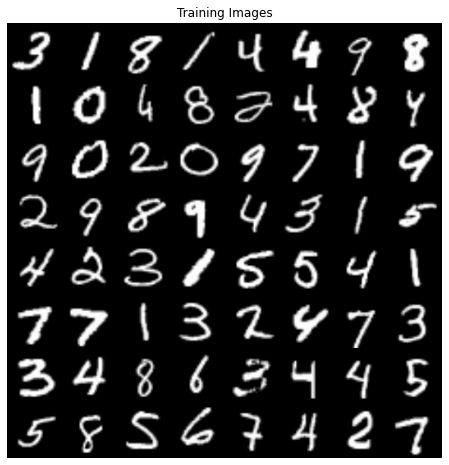

In [4]:
VerifyDataloader(d.data).VerifyData()

In [5]:
# custom weights initialization called on netG and netD
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [7]:
# Declaring generator and applying weights
gen_model = Generator().to(device=DEVICE)
gen_model.apply(initialize_weights);
gen_opt = torch.optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [8]:
# Declaring discrimator and applying weights
dis_model = Discriminator().to(device=DEVICE)
dis_model.apply(initialize_weights);
dis_opt = torch.optim.Adam(dis_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [9]:
train = TrainGAN(gen_opt, dis_opt, criterion)
for epoch in range(NUM_EPOCHS):
    train.train(gen_model, dis_model, d.data, epoch)
    print('Epoch: %d\tDiscriminant Loss: %.4f\tGenerator Loss: %.4f'
                    % (epoch, train.dis_loss[-1], train.gen_loss[-1]))

Epoch: 0	Discriminant Loss: 0.2502	Generator Loss: 3.5254
Epoch: 1	Discriminant Loss: 0.3492	Generator Loss: 3.8824
Epoch: 2	Discriminant Loss: 0.1866	Generator Loss: 4.1479
Epoch: 3	Discriminant Loss: 0.6276	Generator Loss: 1.1362
Epoch: 4	Discriminant Loss: 0.0940	Generator Loss: 2.9695


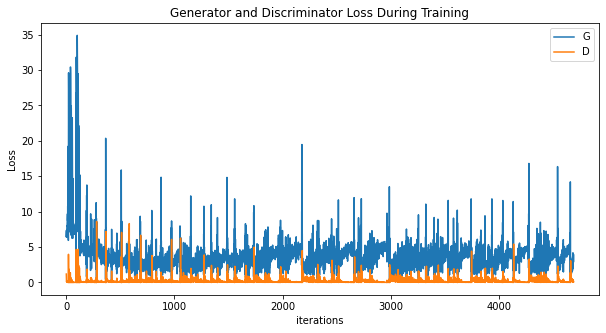

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train.gen_loss,label="G")
plt.plot(train.dis_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

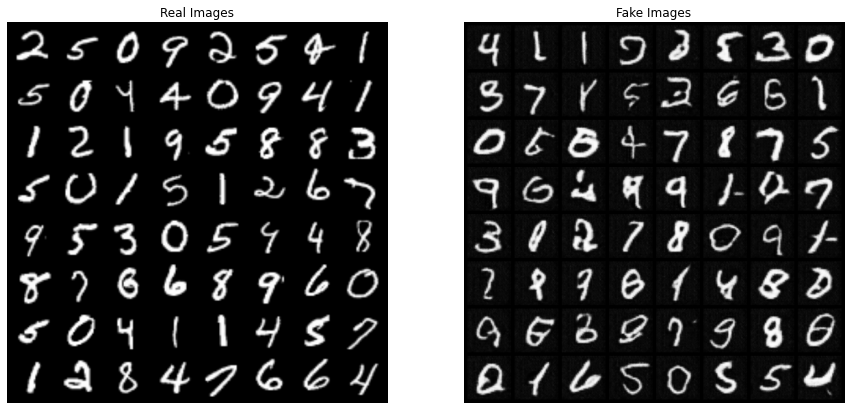

In [11]:
img_list = list()
with torch.no_grad():
    fake = gen_model(fixed_noise).detach().cpu()
img_list.append(torchvision.utils.make_grid(fake, padding=5, normalize=True))

real_batch = next(iter(d.data))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [12]:
from DCGAN_ECOG import Generator as Generator_ecog, Discriminator as Discriminator_ecog

In [13]:
d1 = DF('401')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [14]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, device=device)

In [15]:
# Declaring generator and applying weights
gen_model = Generator_ecog().to(device=DEVICE)
gen_model.apply(initialize_weights);
gen_opt = torch.optim.Adam(gen_model.parameters(), lr=0.001, betas=(0.5, 0.999))

In [16]:
# Declaring discrimator and applying weights
dis_model = Discriminator_ecog().to(device=DEVICE)
dis_model.apply(initialize_weights);
dis_opt = torch.optim.Adam(dis_model.parameters(), lr=0.001, betas=(0.5, 0.999))

In [17]:
train = TrainGAN(gen_opt, dis_opt, criterion)
for epoch in range(25):
    train.train_ecog(gen_model, dis_model, d1.train_data, epoch)
    print('Epoch: %d\tDiscriminant Loss: %.4f\tGenerator Loss: %.4f'
                    % (epoch, train.dis_loss[-1], train.gen_loss[-1]))

Epoch: 0	Discriminant Loss: 0.0859	Generator Loss: 6.1718
Epoch: 1	Discriminant Loss: 0.3058	Generator Loss: 4.8764
Epoch: 2	Discriminant Loss: 0.7535	Generator Loss: 4.4727
Epoch: 3	Discriminant Loss: 1.2635	Generator Loss: 3.4156
Epoch: 4	Discriminant Loss: 0.0050	Generator Loss: 5.8956
Epoch: 5	Discriminant Loss: 0.3433	Generator Loss: 2.9261
Epoch: 6	Discriminant Loss: 0.7218	Generator Loss: 6.4693
Epoch: 7	Discriminant Loss: 1.1875	Generator Loss: 6.5116
Epoch: 8	Discriminant Loss: 0.0801	Generator Loss: 1.8234
Epoch: 9	Discriminant Loss: 0.1904	Generator Loss: 3.6301
Epoch: 10	Discriminant Loss: 1.4584	Generator Loss: 5.7589
Epoch: 11	Discriminant Loss: 0.7907	Generator Loss: 7.2066
Epoch: 12	Discriminant Loss: 0.8419	Generator Loss: 6.2137
Epoch: 13	Discriminant Loss: 3.4497	Generator Loss: 8.3755
Epoch: 14	Discriminant Loss: 0.0434	Generator Loss: 4.7882
Epoch: 15	Discriminant Loss: 0.4614	Generator Loss: 7.3280
Epoch: 16	Discriminant Loss: 0.0042	Generator Loss: 5.9137
Epoch: 

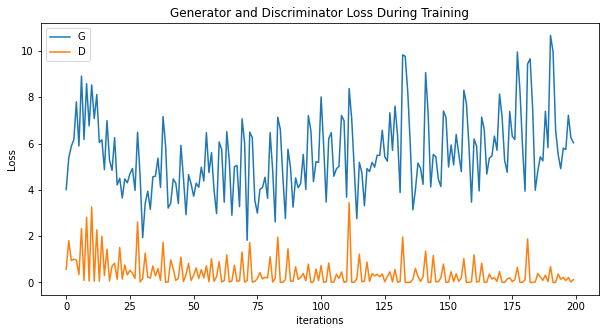

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train.gen_loss,label="G")
plt.plot(train.dis_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

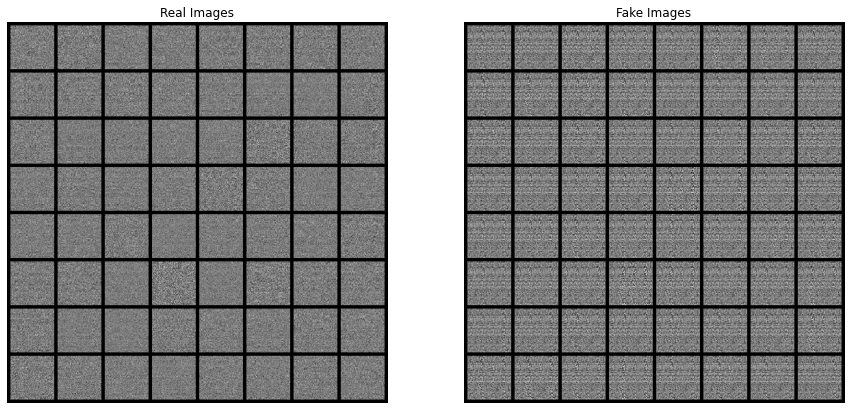

In [19]:
img_list = list()
with torch.no_grad():
    fake = gen_model(fixed_noise).detach().cpu()
img_list.append(torchvision.utils.make_grid(fake[:,None,:], padding=5, normalize=True))

real_batch = next(iter(d1.train_data))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.tensor(d1.train_data.dataset[:64,None,0].tolist()).to(DEVICE)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [20]:

map = dict()

fake = gen_model(fixed_noise).detach().cpu()

fake.shape

torch.Size([64, 64, 64])

In [21]:
counter = 0
map = dict()
for i in d1.train_data.dataset:
    val = [str(x) for x in i[1]]
    val = ' '.join(val)
    if not val in map.keys():
        map[val] = counter
        counter += 1

In [22]:
X = list()
Y = list()
for i in d1.train_data.dataset:
    ecog = np.array(i[0])
    ecog = np.reshape(ecog, (-1))
    X.append(ecog)
    val = [str(x) for x in i[1]]
    val = ' '.join(val)
    Y.append(map[val])

In [23]:
from sklearn import svm
neigh = svm.SVC(kernel='sigmoid')
neigh = neigh.fit(X, Y)
print(Y.count(18))

8


In [24]:
X1 = list()
fake = gen_model(fixed_noise).detach().cpu().numpy()
for i in fake:
    ecog = np.reshape(i, (-1))
    X1.append(ecog)
pred = neigh.predict(X1)
pred

array([41, 10, 41, 41, 12, 41, 41, 41, 41, 41, 41, 41, 19, 10, 12, 10, 41,
       19, 41, 10, 19, 10, 41, 41, 10, 19, 12, 41, 41, 41, 41, 10, 19, 19,
       41, 10, 19, 41, 12, 12, 10, 10, 10, 19, 41, 41, 41, 10, 10, 19, 41,
       41, 19, 41, 19, 41, 41, 41, 10, 10, 41, 41, 41, 10])

In [25]:
vocab = dict()
for var in map:
    tmp = [int(x) for x in var.split()]
    vocab[map[var]] = tmp


In [26]:
for i in pred:
    print(type(i), i)
    print(vocab[i])
    break

<class 'numpy.int64'> 41
[0, 778, 1675, 1258, 192, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
fake = np.reshape(fake, (-1, 64, 64))
sentences = [vocab[i] for i in pred]


In [28]:
def make_model():
    enc = Encoder(INPUT_DIM, 
                D_MODEL, 
                N, 
                H, 
                D_FF, 
                DROPOUT,
                d1.max_ecog_sz
                )
    dec = Decoder(OUTPUT_DIM, 
                D_MODEL, 
                N, 
                H, 
                D_FF, 
                DROPOUT
                )
    return Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX).to(device)

In [29]:
model = make_model()

In [30]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [31]:
t = Train(d1.train_data.dataset, fake, sentences)

In [32]:
fake.shape
d1.train_data.dataset[:, 0][0].shape

(64, 64)

In [33]:
from validate import Validate
import math

In [34]:
t_val = Validate(d1.train_data.dataset, d1.vocab)
v_val = Validate(d1.val_data.dataset, d1.vocab)
test_val = Validate(d1.test_data.dataset, d1.vocab)
wer_val_data = list()
wer_train_data = list()

In [35]:
import time
for epoch in range(30):
    
    start_time = time.time()
    train_loss, optimizer, criterion = t.train_fake(model, optimizer, criterion, CLIP)
    if epoch % 5 == 0:
        wer_train_data.append(t_val.validate(model))
        wer_val_data.append(v_val.validate(model))
        if v_val.min_WER == v_val.WER:
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/EFC401/model.pt')
    end_time = time.time()
    epoch_mins, epoch_secs = t.epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tWER Training Data: {wer_train_data[-1]} | WER Validation Data: {wer_val_data[-1]}')
    print()

Epoch: 01 | Time: 0m 20s
	Train Loss: 6.135 | Train PPL: 461.536
	WER Training Data: 0.9687499999999993 | WER Validation Data: 0.9691111111111111

Epoch: 02 | Time: 0m 9s
	Train Loss: 3.658 | Train PPL:  38.802
	WER Training Data: 0.9687499999999993 | WER Validation Data: 0.9691111111111111

Epoch: 03 | Time: 0m 9s
	Train Loss: 1.879 | Train PPL:   6.547
	WER Training Data: 0.9687499999999993 | WER Validation Data: 0.9691111111111111

Epoch: 04 | Time: 0m 9s
	Train Loss: 1.065 | Train PPL:   2.901
	WER Training Data: 0.9687499999999993 | WER Validation Data: 0.9691111111111111

Epoch: 05 | Time: 0m 9s
	Train Loss: 0.844 | Train PPL:   2.326
	WER Training Data: 0.9687499999999993 | WER Validation Data: 0.9691111111111111

Epoch: 06 | Time: 0m 18s
	Train Loss: 0.780 | Train PPL:   2.182
	WER Training Data: 0.9733931623931626 | WER Validation Data: 0.9737777777777779

Epoch: 07 | Time: 0m 9s
	Train Loss: 0.754 | Train PPL:   2.125
	WER Training Data: 0.9733931623931626 | WER Validation Da